In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LogisticRegression
from sklearn.ensemble         import RandomForestClassifier
import xgboost                 as xgb
from sklearn.metrics          import (
    confusion_matrix, roc_curve, roc_auc_score,
    classification_report
)

# Seaborn styling
sns.set(style="whitegrid")

# Load your engineered training set (adjust path if needed)
df = pd.read_csv('../output/engineered_train.csv')
X  = df.drop(columns=['PassengerId','Transported'])
y  = df['Transported'].astype(int)

# Quick peek
df.head()



,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_S,Side_Unknown,Transported
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,...,False,False,False,False,False,False,False,False,False,0
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,0,...,False,False,False,True,False,False,False,True,False,1
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,...,False,False,False,False,False,False,False,True,False,0
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,...,False,False,False,False,False,False,False,True,False,0
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,...,False,False,False,True,False,False,False,True,False,1


In [2]:
# 1) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) Scale numeric features for LR & XGBoost
num_cols = ['Age','CabinNum','TotalSpend','GroupSize']
scaler   = StandardScaler().fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)



Train shape: (6954, 26) Val shape: (1739, 26)


In [5]:
# -- Logistic Regression --
lr_params = {'C': [0.01,0.1,1,10], 'solver': ['liblinear']}
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=500),
    lr_params, cv=5, scoring='f1'
)
lr_grid.fit(X_train, y_train)

# -- Random Forest --
xgb_params = {
    'n_estimators':   [100, 200],
    'max_depth':      [3, 5],
    'learning_rate':  [0.01, 0.1]
}

xgb_grid = GridSearchCV(
    xgb.XGBClassifier(
        # no use_label_encoder parameter any more
        eval_metric='logloss',
        random_state=42
    ),
    xgb_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

# 1. Grab the best estimator from your grid search
best_model = xgb_grid.best_estimator_

# 2. Double‑check it’s there
print(best_model)


print("Best XGB params:", xgb_grid.best_params_)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)
Best XGB params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


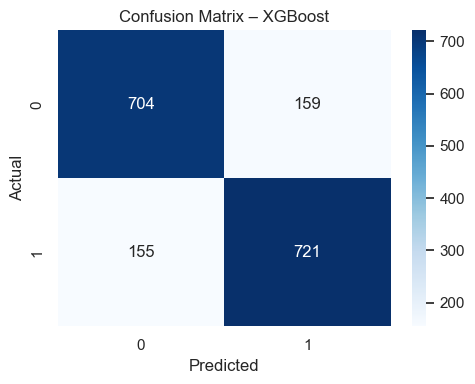

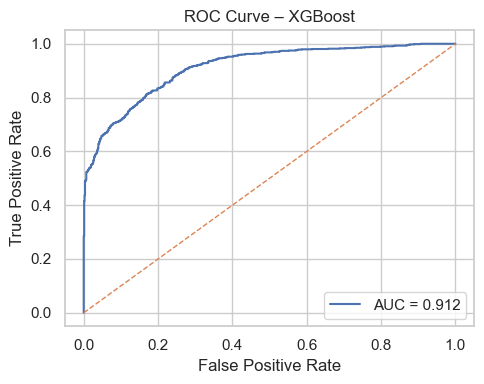

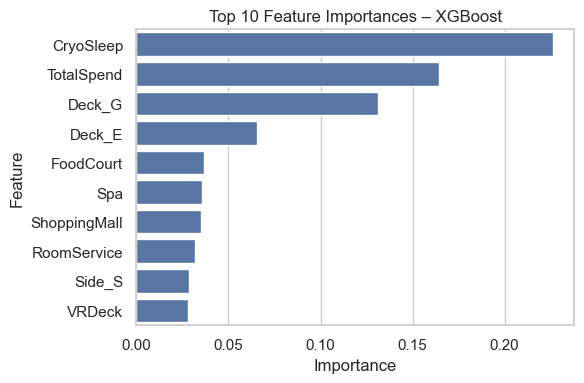

✅ Plots saved to ../plots/


In [4]:
# pick your champion model
best_model = xgb_grid.best_estimator_

# predictions
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:, 1]

# 1) Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../plots/confusion_matrix.png')
plt.show()
plt.close()

# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
auc_score   = roc_auc_score(y_val, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], '--', linewidth=1)
plt.title('ROC Curve – XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../plots/roc_curve.png')
plt.show()
plt.close()

# 3) Feature Importance
importances = pd.Series(
    best_model.feature_importances_,
    index=X.columns
)
top10 = importances.sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=top10.values, y=top10.index)
plt.title('Top 10 Feature Importances – XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../plots/feature_importance.png')
plt.show()
plt.close()

print("✅ Plots saved to ../plots/")


In [6]:
import joblib

# these names should already exist in the notebook
joblib.dump(best_model, "../model/xgb_model.pkl")
joblib.dump(scaler,   "../model/scaler.pkl")
joblib.dump(list(X.columns), "../model/feature_cols.pkl")


['../model/feature_cols.pkl']